In [ ]:
!pip install torch transformers datasets
import matplotlib.pyplot as plt



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


seleccion y cargue de dataset de noticias

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Selecciona algunas categorías para clasificación multiclase
categories = ['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Datos de entrenamiento y prueba
train_texts, train_labels = newsgroups_train.data, newsgroups_train.target
test_texts, test_labels = newsgroups_test.data, newsgroups_test.target


preprocesamiento y tokerizacoin

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

train_encodings = tokenize_texts(train_texts)
test_encodings = tokenize_texts(test_texts)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Convertimos los datos en un formato compatible con PyTorch.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class NewsGroupsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsGroupsDataset(train_encodings, train_labels)
test_dataset = NewsGroupsDataset(test_encodings, test_labels)


definir y entrenar modelo RNN (LSTM)

In [ ]:
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])

vocab_size = tokenizer.vocab_size
model_rnn = SimpleLSTM(vocab_size, embed_size=128, hidden_size=256, output_size=len(categories)).to("cuda")

# Configuración de entrenamiento
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entrenamiento
def train_rnn(model, dataset):
    model.train()
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
    for batch in train_loader:
       # input_ids, labels = batch['input_ids'], batch['labels']#.to("cuda")
        input_ids, labels = batch['input_ids'].to("cuda"), batch['labels'].to("cuda")
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

for epoch in range(3):
    train_rnn(model_rnn, train_dataset)


<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Definir y Entrenar el Modelo Transformer (BERT)
Usamos BertForSequenceClassification para aprovechar un transformer preentrenado

KEY b522cf75c571a3c931bf52dbb287468fa5184b60

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model_transformer = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(categories)).to("cuda")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,  # Registra la pérdida cada 10 pasos
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model_transformer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Lista para almacenar las pérdidas de cada época
transformer_loss_values = []

# Bucle manual para registrar la pérdida al final de cada época
for epoch in range(training_args.num_train_epochs):
    trainer.train()
    # Almacenar la última pérdida de entrenamiento de `log_history`
    transformer_loss_values.append(trainer.state.log_history[-1]['train_loss'])

print("Transformer Loss Values:", transformer_loss_values)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.455400,0.424924
2,0.172800,0.252714
3,0.004500,0.269820


<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.002200,0.209118
2,0.022200,0.290813
3,0.000600,0.266475


<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.000500,0.254944
2,0.000400,0.361800
3,0.000300,0.420838


<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Transformer Loss Values: [0.42791532729058823, 0.01049491484819011, 0.0026713276026554705]


Evaluación de los Modelos
Comparamos los modelos RNN y Transformer en el conjunto de prueba usando exactitud y otras métricas.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, dataset):
    model.eval()
    loader = DataLoader(dataset, batch_size=16)
    predictions, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to("cuda")
            label = batch['labels'].to("cuda")
            output = model(input_ids)
            logits = output if isinstance(output, torch.Tensor) else output.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())
    return accuracy_score(labels, predictions), precision_recall_fscore_support(labels, predictions, average="weighted")

# Evaluación
accuracy_rnn, metrics_rnn = evaluate(model_rnn, test_dataset)
accuracy_transformer, metrics_transformer = evaluate(model_transformer, test_dataset)

print("RNN Accuracy:", accuracy_rnn, "Metrics:", metrics_rnn)
print("Transformer Accuracy:", accuracy_transformer, "Metrics:", metrics_transformer)


<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


RNN Accuracy: 0.44503664223850764 Metrics: (0.45397202354437616, 0.44503664223850764, 0.4461537909896623, None)
Transformer Accuracy: 0.938707528314457 Metrics: (0.9414936967587951, 0.938707528314457, 0.9387276793279602, None)


VISUALIZACION DE LOS PARAMETROS

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("RNN Model Parameters:", count_parameters(model_rnn))
print("Transformer Model Parameters:", count_parameters(model_transformer))


RNN Model Parameters: 4303108
Transformer Model Parameters: 109485316


Modificar Entrenamiento de RNN para Guardar Pérdida y Precisión

---



In [ ]:
def train_rnn(model, dataset, epochs=3):
    model.train()
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, labels = batch['input_ids'].to("cuda"), batch['labels'].to("cuda")
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")
    return losses

rnn_losses = train_rnn(model_rnn, train_dataset)


<ipython-input-7-9bfbd6901ad1>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/3, Loss: 0.775501845576239
Epoch 2/3, Loss: 0.4971275695777954
Epoch 3/3, Loss: 0.30398742281270363


para los datos del transformers hugginfaces ya guarda se llama a la variable

In [ ]:
transformer_losses = trainer.state.log_history
print(transformer_losses)


[{'loss': 0.0006, 'grad_norm': 0.008216173388063908, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.07092198581560284, 'step': 10}, {'loss': 0.0007, 'grad_norm': 0.006250182166695595, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.14184397163120568, 'step': 20}, {'loss': 0.0006, 'grad_norm': 0.007652137894183397, 'learning_rate': 3e-06, 'epoch': 0.2127659574468085, 'step': 30}, {'loss': 0.0006, 'grad_norm': 0.007171629462391138, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.28368794326241137, 'step': 40}, {'loss': 0.0006, 'grad_norm': 0.0077387192286551, 'learning_rate': 5e-06, 'epoch': 0.3546099290780142, 'step': 50}, {'loss': 0.0006, 'grad_norm': 0.00794751662760973, 'learning_rate': 6e-06, 'epoch': 0.425531914893617, 'step': 60}, {'loss': 0.0006, 'grad_norm': 0.007478378713130951, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.49645390070921985, 'step': 70}, {'loss': 0.0079, 'grad_norm': 0.006030155811458826, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.5673

In [ ]:
transformer_loss_values = [entry['train_loss'] for entry in transformer_losses if 'train_loss' in entry]
print("Transformer Loss Values:", transformer_loss_values)



Transformer Loss Values: [0.0026713276026554705]


Graficar la Pérdida de Entrenamiento

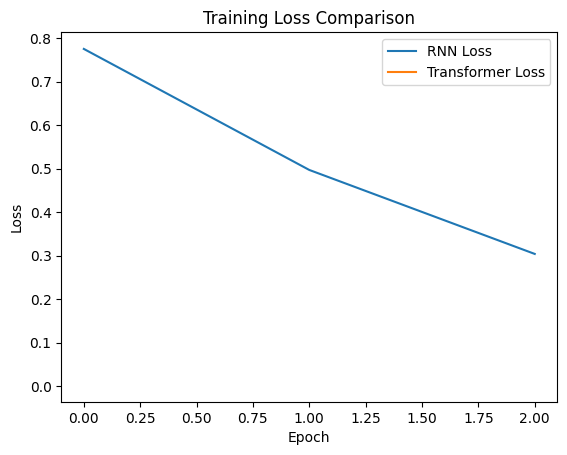

In [ ]:
transformer_loss_values = [entry['train_loss'] for entry in transformer_losses if 'train_loss' in entry]
plt.plot(rnn_losses, label="RNN Loss")
plt.plot(transformer_loss_values, label="Transformer Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()


Graficar la Precisión, Recall y F1-score

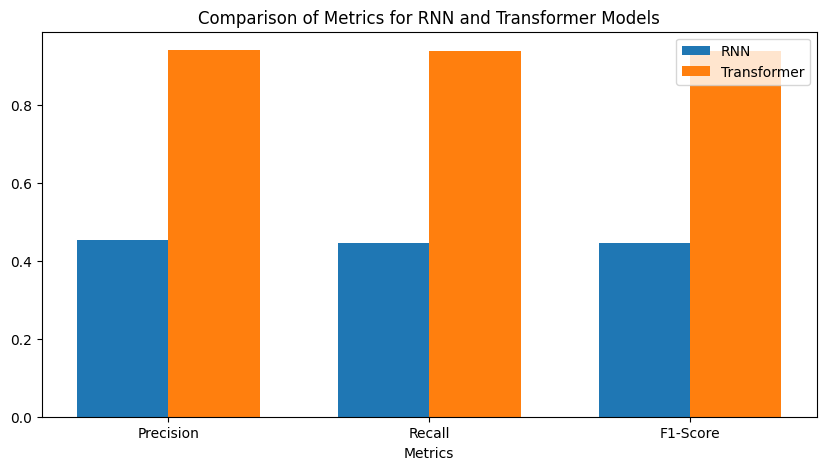

In [ ]:
import numpy as np

# Métricas de evaluación
precision_rnn, recall_rnn, f1_rnn = metrics_rnn[0], metrics_rnn[1], metrics_rnn[2]
precision_transformer, recall_transformer, f1_transformer = metrics_transformer[0], metrics_transformer[1], metrics_transformer[2]

# Graficar las métricas
labels = ["Precision", "Recall", "F1-Score"]
rnn_scores = [precision_rnn, recall_rnn, f1_rnn]
transformer_scores = [precision_transformer, recall_transformer, f1_transformer]

x = np.arange(len(labels))  # Posición de los labels
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, rnn_scores, width, label="RNN")
ax.bar(x + width/2, transformer_scores, width, label="Transformer")

# Etiquetas y leyendas
ax.set_xlabel("Metrics")
ax.set_title("Comparison of Metrics for RNN and Transformer Models")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
